I will be living in the Chicago area soon as part of my Master's program at the University of Chicago. As someone who enjoyed using the electric bikes and scooters located on my undergrad campus, UCLA, I wanted to analyze some behaviors and patterns from the Chicago bike-sharing system that also services the UChicago campus area, Divvy. Having noticed that Divvy has a membership program - I set up this quick case study to analyze the differences between non-member riders (which I will call casual riders) which pay for Divvy bikes using single ride or full-day passes and the Divvy members.

Divvy provides its past ride data [here](https://divvy-tripdata.s3.amazonaws.com/index.html). Learn more about Divvy's data collection and terms [here](https://divvybikes.com/system-data) I am using the ride data from the past year, so from May 2022 to May 2023.

**Disclaimer**: I do not own any of data in this study. All rights are with Divvy and Motivate.


## Preliminaries
First we need to import everything we need.

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

These three libraries will be our main force in loading, processing, and then visualizing the datasets.

## Loading the data
Now we want to load the datasets. I am using the Divvy Bikes data from 05/2022 to 05/2023, where *month_k.csv* represents the *k*-th month in 05/2022 to 05/2023. Thus, *month_1.csv* represents 05/2022, etc and *month_13.csv* represents the data from 05/2023. I am loading all of these datasets into a list of DataFrames just so we have all our datasets on hand.

In [3]:
df_list = []
for i in range(1,14):
    df_list.append(pd.read_csv('month_' + str(i) + '.csv'))

As a quick test, we can check that we loaded everything correctly by previewing each DataFrame.

In [4]:
for df in df_list:
    print(df.head(3))

            ride_id rideable_type           started_at             ended_at  \
0  EC2DE40644C6B0F4  classic_bike  2022-05-23 23:06:58  2022-05-23 23:40:19   
1  1C31AD03897EE385  classic_bike  2022-05-11 08:53:28  2022-05-11 09:31:22   
2  1542FBEC830415CF  classic_bike  2022-05-26 18:36:28  2022-05-26 18:58:18   

                  start_station_name start_station_id  \
0             Wabash Ave & Grand Ave     TA1307000117   
1  DuSable Lake Shore Dr & Monroe St            13300   
2            Clinton St & Madison St     TA1305000032   

              end_station_name end_station_id  start_lat  start_lng  \
0       Halsted St & Roscoe St   TA1309000025  41.891466 -87.626761   
1  Field Blvd & South Water St          15534  41.880958 -87.616743   
2      Wood St & Milwaukee Ave          13221  41.882242 -87.641066   

     end_lat    end_lng member_casual  
0  41.943670 -87.648950        member  
1  41.886349 -87.617517        member  
2  41.907655 -87.672552        member  
         

## Processing

Now we can begin processing the datasets. First, I am going to add a column to each DataFrame that includes the total trip time for each trip, in minutes. **Note**: I am using a *minutes* format, not *minutes*:*seconds* format.

In [6]:
for df in df_list:
    df[['started_at','ended_at']] = df[['started_at','ended_at']].apply(pd.to_datetime)
    df['ride_length'] = (df['ended_at'] - df['started_at'])/np.timedelta64(1, 'm')

Once again, we can preview the *ride_length* column of each DataFrame to make sure we implemented it correctly.

In [21]:
for df in df_list:
    print(df['ride_length'].head(3))

Now I will add another column to each DataFrame that includes the day of week when the ride started. **Note**: in pandas, dayofweek is formatted where 0 is Monday, 6 is Sunday, which is different from Excel/Google Sheets where 1 is Sunday, and 7 is Saturday.

In [58]:
for df in df_list:
    df['day_of_week'] = df['started_at'].dt.dayofweek

In [ ]:
for df in df_list:
    print(df['day_of_week'].head(3))

## Analysis
Now we can move on to analyzing the datasets in more detail. We will first analyze the average, max, and most common day of week for Divvy bike rides across each month.

In [37]:
mean_ride_lengths = []
max_ride_lengths = []
most_common_day_of_week = []
for df in df_list:
    mean_ride_lengths.append(df['ride_length'].mean())
    max_ride_lengths.append(df['ride_length'].max())
    most_common_day_of_week.append(df['day_of_week'].mode().iat[0])

In [38]:
months = ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']
mean_month_df = pd.DataFrame({'month': months, 'mean': mean_ride_lengths})

As a quick check, we can plot the average ride duration against the month for some preliminary insights.

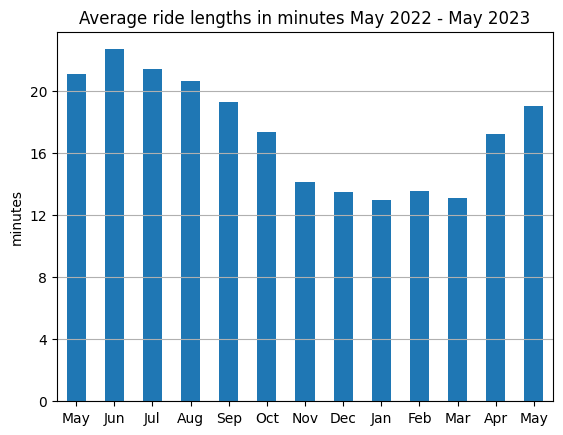

In [39]:
ax = mean_month_df.plot.bar(x = 'month', y= 'mean',rot=0)
ax.set_xlabel("")
ax.set_ylabel("minutes")
ax.legend().set_visible(False)
ax.yaxis.grid(True)
ax.set_yticks(np.arange(0,max(mean_ride_lengths),4))
ax.set_title("Average ride lengths in minutes May 2022 - May 2023")
plt.show()

The average ride length decreases steeply as the months transition into November-March, which is sensible due to the colder weather. Similarly, the average ride length hits a high during June, which can also be explained by warmer/overall nicer weather.

This average is the average for all riders though - so we can modify our analysis to differentiate between members and casual riders.

In [16]:
casual_means = []
member_means = []

for df in df_list:
    casual_means.append(df.where(df['member_casual'] == 'casual')['ride_length'].mean())
    member_means.append(df.where(df['member_casual'] == 'member')['ride_length'].mean())

casual_member_means = pd.DataFrame({'month': months, 'casual_mean': casual_means, 'member_mean': member_means})

In [40]:
casual_member_means

,month,casual_mean,member_mean
0,May,30.869612,13.366677
1,Jun,32.096975,13.998434
2,Jul,29.278088,13.718340
3,Aug,29.310048,13.384163
4,Sep,27.985169,12.950140
5,Oct,26.387427,11.958171
6,Nov,21.286235,11.128622
7,Dec,22.289564,10.619488
8,Jan,22.914840,10.361764
9,Feb,23.192516,10.714270


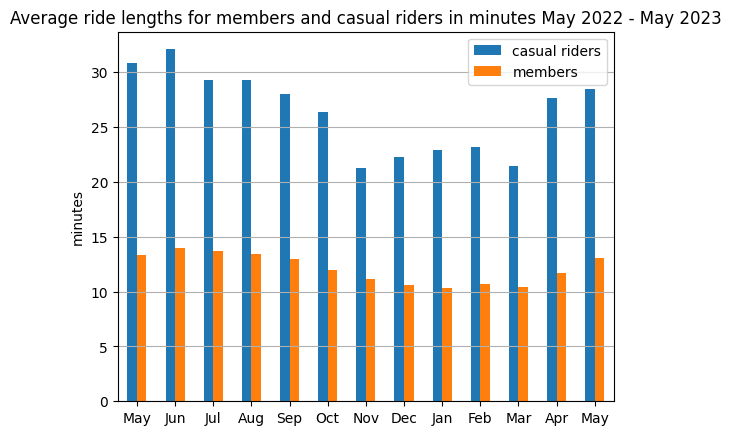

In [30]:
ax = casual_member_means.plot.bar(x='month', y=['casual_mean','member_mean'],rot=0)
ax.set_xlabel("")
ax.set_ylabel("minutes")
ax.yaxis.grid(True)
ax.set_title("Average ride lengths for members and casual riders in minutes May 2022 - May 2023")
ax.legend(['casual riders', 'members'])
plt.show()

The average ride length for casual riders far exceeds that of members, which is sensible and can be explained by casual riders purchasing one-time/day passes, thus will ride less often, but for longer - whereas members have annual passes and thus can ride at any time, so will ride more often, but for shorter lengths. We can confirm this by examining the actual number of rides made by members vs. casual riders.

In [99]:
casual_rides = []
member_rides = []
for df in df_list:
    casual_rides.append(df['member_casual'].value_counts()['casual'])
    member_rides.append(df['member_casual'].value_counts()['member'])

casual_member_rides = pd.DataFrame({'month': months, 'casual_rides': casual_rides, 'member_rides': member_rides})

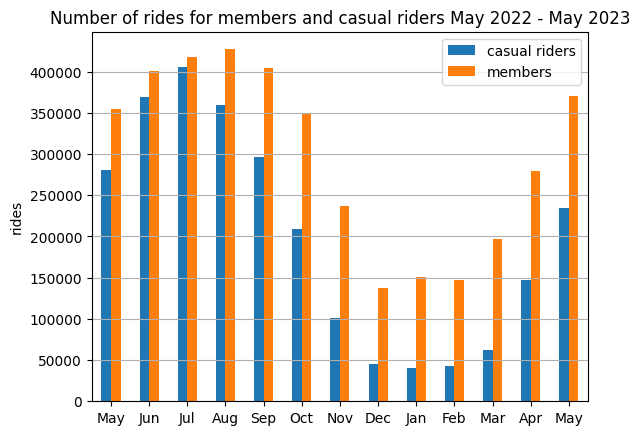

In [100]:
ax = casual_member_rides.plot.bar(x='month', y=['casual_rides','member_rides'],rot=0)
ax.set_xlabel("")
ax.set_ylabel("rides")
ax.yaxis.grid(True)
ax.set_title("Number of rides for members and casual riders May 2022 - May 2023")
ax.legend(['casual riders', 'members'])
plt.show()

This result supports our hypothesis that members ride more often than casual riders. While both casual riders and members experienced a dropoff in number of rides as the weather becomes colder, the dropoff is much steeper for casual riders than for members. From this we can infer that casual riders are much less likely to go for a ride than members when the weather is worse/colder. We can also examine and breakdown these patterns on a day-of-week basis.

In [65]:
pivot_table_list_means = []
pivot_table_list_counts = []
for df in df_list:
    pivot_table_list_means.append(df.pivot_table(values='ride_length',index='member_casual',columns='day_of_week',aggfunc=np.average))
    pivot_table_list_counts.append(df.pivot_table(values='ride_id',index='member_casual',columns='day_of_week',aggfunc=np.count_nonzero))

In [67]:
for table in pivot_table_list_means:
    print(table)

day_of_week            0          1          2          3          4  \
member_casual                                                          
casual         32.440332  26.742422  25.792914  29.260581  29.475371   
member         13.392301  12.778912  12.321286  13.158724  12.818710   

day_of_week            5          6  
member_casual                        
casual         33.393082  33.719398  
member         14.705749  14.478485  
day_of_week            0          1          2          3          4  \
member_casual                                                          
casual         31.476297  31.452828  29.065671  30.195765  32.641569   
member         13.418692  13.639113  13.105556  13.704779  13.803296   

day_of_week            5          6  
member_casual                        
casual         32.226331  36.136855  
member         15.173553  15.683748  
day_of_week            0          1          2          3          4  \
member_casual                                 

In [101]:
for table in pivot_table_list_counts:
    print(table)

day_of_week        0      1      2      3      4      5      6
member_casual                                                 
casual         47469  35067  24066  33399  32238  52855  55321
member         62061  59543  45097  51663  42310  44995  48774
day_of_week        0      1      2      3      4      5      6
member_casual                                                 
casual         37005  38825  48387  57978  55868  65137  65851
member         46791  54986  68797  73501  57322  49694  49062
day_of_week        0      1      2      3      4      5      6
member_casual                                                 
casual         43971  41455  42850  47793  56505  95230  78251
member         49850  57524  59611  61155  61644  68869  58780
day_of_week        0      1      2      3      4      5      6
member_casual                                                 
casual         42362  51509  51488  42353  56868  66190  48154
member         62603  76718  76616  57510  58703  51886

Our previous hypothesis that members ride more frequently but for shorter rides turns out to be true, as in most months, members have shorter rides compared to casual riders in every day of the week, and members have more rides per day than casual riders during the "solid weekdays" (i.e Monday-Thursday), but during the weekends (Friday included), there are more casual riders than members, perhaps due to not having work and thus enjoying a bike ride as a recreational hobby on the weekend.

So far, we have been analyzing the trends/characteristics of the casual/member riders on a month-by-month or day-of-week basis. This allowed us to analyze the difference in behaviors between the two groups based on date and time. Now we will proceed by merging the datasets and analyze the data as a whole, as we have finished our analysis of the date-dependent characteristics. 

In [77]:
df = pd.concat(df_list, ignore_index=True)

We can look at the breakdown between casual riders and members for electric bikes, classic bikes, etc.

In [80]:
casual_member_bike_breakdown = df.pivot_table(values='ride_id',index='member_casual',columns='rideable_type',aggfunc=np.count_nonzero)
casual_member_bike_breakdown

rideable_type,classic_bike,docked_bike,electric_bike
member_casual,,,
casual,983844.0,183610.0,1425034.0
member,1928636.0,NaN,1942764.0


We see that of the *docked_bike* ride type, there are no rides by members. This is a puzzling result and the naming *docked_bike* is unclear as to what kind of bike it is, as all Divvy bikes are able to be docked at Divvy stations. My closest guess is the *docked_bike* represents classic Divvy bikes that were manufactured before the 2019/2020 expansion by Divvy/Lyft to manufacture electric bikes. Even if we consider all the *docked_bike* rides to be classic bikes, the result still shows that casual members overall use electric bikes more than classic bikes, whereas Divvy members seem evenly split between classic bikes and electric bikes.

In [85]:
print("proportion of casual rides using electric bikes (minimum):", (1425034.0)/(983844.0+183610.0+1425034.0))
print("proportion of casual rides using electric bikes (maximum):", (1425034.0+183610.0)/(983844.0+183610.0+1425034.0))
print("proportion of member rides using electric bikes:", 1942764.0/(1928636.0+1942764.0))

proportion of casual rides using electric bikes (minimum): 0.549678147015531
proportion of casual rides using electric bikes (maximum): 0.6205020042522859
proportion of member rides using electric bikes: 0.5018246629126414


So the proportion of casual rides using electric bikes is between 54.96% and 62.05%, and for member rides it is a much more balanced 50.18%.

This breakdown can possibly be attributed to Divvy's pricing plans. Members enjoy reduced prices on electric bikes from a $0.42/min without membership to $0.17/min with, which is the same rate for classic bikes with or without membership, but Divvy members enjoy 45 minutes of riding for free on classic bikes, in addition to free unlocks, whereas casual riders would have to pay $1 to unlock bikes without a day pass. 

We can also analyze the average ride times for the entire year between casual riders and members.

In [94]:
casual_member_yearly_mean = df.pivot_table(values='ride_length',index='member_casual',aggfunc=np.average)
casual_member_yearly_mean

,ride_length
member_casual,
casual,28.495682
member,12.548860


This average is consistent with our findings month-by-month on the difference in average ride duration for members and casual riders.

## Summary of findings
We have learned several distinct characteristics between Divvy's casual riders and Divvy's member riders.

* Casual riders ride much less frequently than member riders, but have longer rides.
* Casual riders are much more likely to stop riding when the weather is colder than member riders.
* Casual riders mainly ride during the weekends, unlike members.
* Casual riders overall prefer electric bikes to classic bikes, unlike member riders which evenly use both.

If Divvy were to want to increase the number of members among its users, I would recommend:
* Improve the pricing discount for electric bikes even more for members during colder months of the year.
* Offer members a free amount of time riding electric bikes, similar to the free 45 minutes of classic bikes that members already enjoy.
* Partner with local recreation spots/parks to give members more benefits for biking at these locations.

All of these recommendations are aimed at converting those that are on the fence on committing to a membership, as options in the membership would be more attractive to casual riders, who ride less in the colder months, prefer electric bikes, and mainly bike for recreation.